# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

## Wavenet version

[Wavenet Paper](https://arxiv.org/abs/1609.03499)

Complexing the MLP. Wavenet is basically a language model for predicting audio

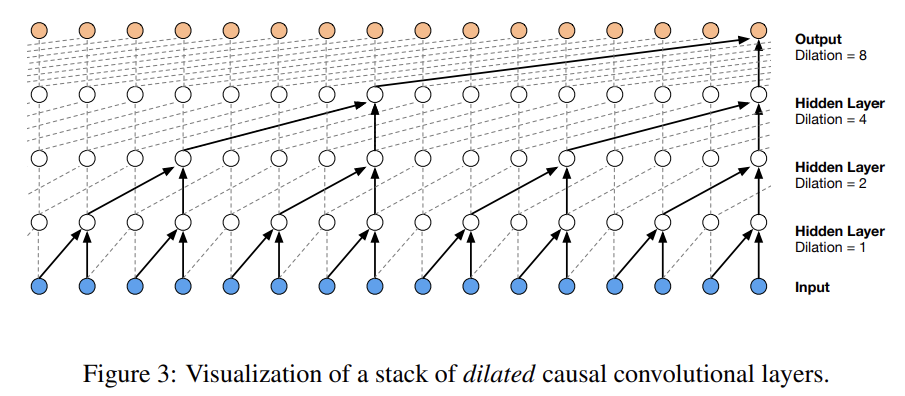

Dilated -> melebar

- 1 neuron would take 2 inputs -> N1
- N1 and N1 will be fused into 1 new neuron (total taking 4 inputs)
- and so on until output neuron

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
words= open('names.txt','r').read().splitlines()
len(words), (max(len(w) for w in words)), words[:5]

(32033, 15, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [15]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
vocab_size

27

In [16]:
import random
random.seed(42)
random.shuffle(words)

In [28]:
#build dataset
block_size = 8 # context length: how many characters do we take to predict the next one?, increase context from 3 to 8 for wavenet
#Wavenet taking 8 characters to predict the next one (the 9th character)
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [18]:
# Near copy paste of the layers we have developed in Part 3, make it similar to torch module

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
      self.eps = eps
      self.momentum = momentum
      self.training = True
      # parameters (trained with backprop)
      self.gamma = torch.ones(dim)
      self.beta = torch.zeros(dim)
      # buffers (trained with a running 'momentum update')
      self.running_mean = torch.zeros(dim)
      self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training: #When training
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else: #When testing
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): # update running mean and variance using a exponential moving average seperately to training process
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean #mini-batch mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar #mini-batch variance
    return self.out
  def parameters(self):
      return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
#Adding module for embedding operation and flatten operation
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class Flatten:
  def __call__ (self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]



In [29]:
torch.manual_seed(42)

In [30]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# C = torch.randn((vocab_size, n_embd)) #Remove since module embedding is added to layer

In [31]:
# layers = [
#   Embedding(vocab_size, n_embd), Flatten(),
#   Linear(n_embd * block_size, n_hidden, bias=False),BatchNorm1d(n_hidden) , Tanh(),
#   Linear(n_hidden, vocab_size)
# ]
model=Sequential([Embedding(vocab_size, n_embd), Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False),BatchNorm1d(n_hidden) , Tanh(),
  Linear(n_hidden, vocab_size)
])

#After increasing context length, it would not make sense to fuse all context into very simple NN, so we add more layers



# with torch.no_grad():
#   # last layer: make less confident
#   # layers[-1].gamma *= 0.1
#   #layers[-1].weight *= 0.1
#   # all other layers: apply gain
#   for layer in layers[:-1]:
#     if isinstance(layer, Linear):
#       layer.weight *= 1.0 #5/3
# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


# parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


22097


Experiment site

In [33]:
rd=torch.randint(0, Xtr.shape[0],(4,)) #Take a look at batch of 4 samples
Xs,Ys = Xtr[rd],Ytr[rd]
logitss=model(Xs)
Xs.shape

torch.Size([4, 8])

In [34]:
model.layers[0].out.shape #Output of embedding layer

torch.Size([4, 8, 10])

In [35]:
model.layers[1].out.shape #Output of flatten layer

torch.Size([4, 80])

In [36]:
model.layers[2].out.shape #Output of linear layer

torch.Size([4, 200])

---------

In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  #embedding removed since is already put into layers
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  # x= Xb
  # for layer in layers:
  #   x = layer(x)
  
  logits=model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3006
  10000/ 200000: 2.3788
  20000/ 200000: 2.4801
  30000/ 200000: 2.3083
  40000/ 200000: 2.0163
  50000/ 200000: 2.5618
  60000/ 200000: 2.5307
  70000/ 200000: 1.8858
  80000/ 200000: 1.8750
  90000/ 200000: 1.6711
 100000/ 200000: 2.2941
 110000/ 200000: 2.2802
 120000/ 200000: 2.2242
 130000/ 200000: 2.0855
 140000/ 200000: 2.4169
 150000/ 200000: 2.0249
 160000/ 200000: 1.9504
 170000/ 200000: 2.2795
 180000/ 200000: 2.1730
 190000/ 200000: 1.9756


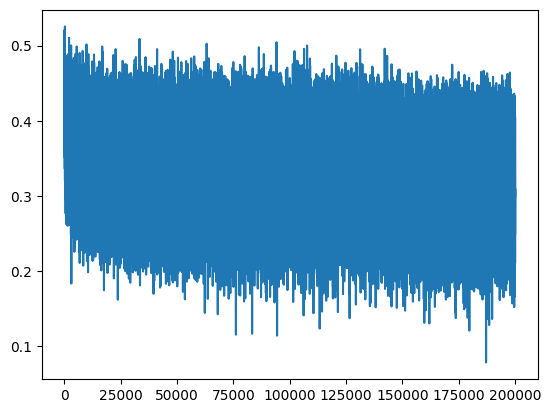

In [23]:
plt.plot(lossi)

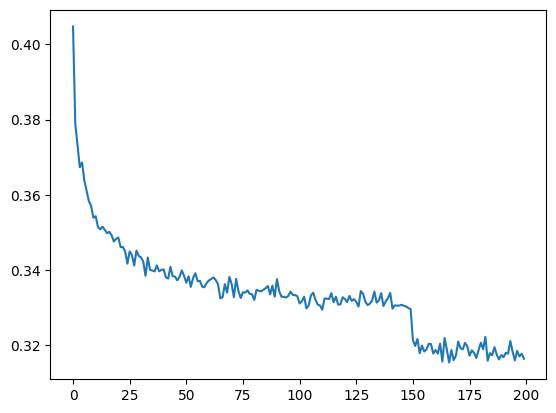

In [24]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [25]:
#put layers to eval mode (RUN BEFORE EVALUATE LOSS AND INFERENCING)
# for layer in layers:
#     layer.training = False

for layer in model.layers:
    layer.training = False

In [26]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # emb= C[x]
  # x= emb.view(emb.shape[0],-1)
  # for layer in layers:
  #     x=layer(x)
  logits=model(x)
  loss=F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0589990615844727
val 2.1079227924346924


In [27]:
# sample from the model, 
# disable training mode to layer first, since batch norm layer is used and the input is only one character/number so variance is not a number=nan
# batch norm is estimating the mean and std via batch, so when only 1 data in batch, it will measure the variance as 0, so it will create bug
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        # emb= C[torch.tensor([context])]
        # x= emb.view(emb.shape[0],-1)
        # for layer in layers:
        #     x=layer(x)
        # logits=x
        
        logits=model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

damiara.
alka.
aris.
tri.
gert.
sayah.
anvi.
caine.
soliette.
cani.
cian.
zaydenthira.
liza.
jer.
grancealynna.
jamaurito.
farashton.
seridianner.
tyre.
dia.
